For this first trial we assume a naive model (LGM) defined as:
$$dx_t = \sigma_t dW_t^{\mathit{N}}$$

Let's define the Numeraire as:
$$N(t, x_t) = \frac{1}{B(0,t)}exp^{H_tx_t + \frac{1}{2}H_t^2\zeta_t}$$
where $H_t$ and $\zeta_t$ are known functions.

With this let's defined the fundamental equation for the pricing of a derivative under the model. The NPV (Net Present Value) is:
$$V_t = V(t, x_t)$$ 
and the deflated version 
$$\overline{V}_t = V(t, x_t) / N(t, x_t)$$

#### Montecarlo simulation

* Brownian path:
$$W_t \sim \mathcal{N}(0,t)$$
$$W[0] = X_0$$
$$W[t] = W[t - 1]  + \mathcal{Z} \cdot \Delta t^{\frac{1}{2}}$$
with 
$$\mathcal{Z} \sim \mathcal{N}(0,1)$$
* X:
$$X_{t + 1} = X_t + \sigma \cdot (W_{t + 1} - W_t)$$

In [41]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import math
from operator import itemgetter
from scipy import stats

class MCSimulation():
    def __init__(self, T, N, X0, sigma, model = 'LGM'):
        self._params = {
            'T':T,
            'N':N,
            'X0':X0,
            'sigma':sigma,
        }
        self._model = model
        
    def simulate(self, nsim = 1e3, show = False):
        T, N, X0, sigma = itemgetter('T', 'N', 'X0', 'sigma')(self._params)
        nsim = int(nsim)
        dt = T / N
        # Brownian simulation
        W, X = np.zeros([N,nsim]), np.zeros([N,nsim])
        # Starting point
        W[0] = X0
        X[0] = X0
        for i in range(1, N):
            W[i] = W[i - 1] + np.random.randn(nsim)
        # X simulation
        for i in range(1, N):
            X[i] = X[i - 1] + sigma * (W[i] - W[i - 1])
        if show:
            X = np.linspace(0, T, N)
        
        return X

In [114]:
# Strike value
Vt = 2
# Set of parameters
T, N, X0, sigma = (1, 100, 0, 0.02)
mcsimulator = MCSimulation(T, N, X0, sigma)
nsims = int(1e2)
mc_paths = mcsimulator.simulate(nsims)
mc_paths_flatten = mc_paths.flatten('C')
deltaTs = np.linspace(0, T, N)
deltaTs = np.tile(deltaTs, nsims).reshape((N, nsims)).T.flatten(order = 'C')
df_x = pd.DataFrame(zip(
    deltaTs,
    mc_paths_flatten
), columns = ['dt', 'xt'])

#### Visualization

In [115]:
mc_paths_transpose = mc_paths.T
deltaTs = np.linspace(0, T, N)
mc_value_per_time_step = np.mean(mc_paths_transpose, axis = 0)

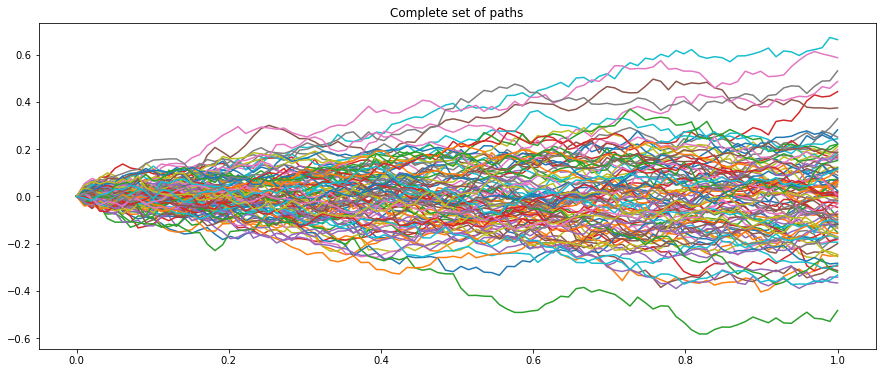

In [116]:
plt.figure(figsize = (15,6))
plt.title('Complete set of paths')
for vect in mc_paths_transpose:
    sns.lineplot(x = deltaTs, y = vect)
plt.show()

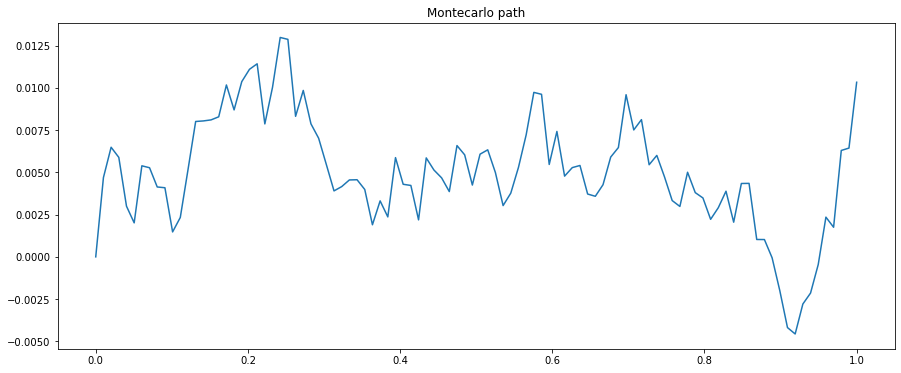

In [117]:
plt.figure(figsize = (15,6))
plt.title('Montecarlo path')
sns.lineplot(x = deltaTs, y = mc_value_per_time_step)
plt.show()

#### Seq2seq with feed forward neural networks

Check:
* https://towardsdatascience.com/how-to-use-custom-losses-with-custom-gradients-in-tensorflow-with-keras-e87f19d13bd5
* https://www.tensorflow.org/guide/autodiff

The idea is to include in the loss function the gradient tape to respect the model!!

In [130]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from typing import Optional

In [185]:
keras.backend.clear_session() 
keras.backend.set_floatx('float64')

In [279]:
class LGM_model(tf.keras.Model):
    
    def __init__(
        self,
        n_steps,
        intermediate_dim=64,
        is_sequential = False,
        name="LGM_NN_model",
        **kwargs
    ):
        super(LGM_model, self).__init__(name=name, **kwargs)
        input_layer = keras.Input(shape=(n_steps,), name='input_nn')
        x = layers.Layer(trainable = False, name = 'adhoc_structure_layer')(input_layer)
        num_layer = 0
        if is_sequential:
            x = layers.GRU(intermediate_dim, name = 'sequential_layer')(x)
            num_layer += 1
        output_layer = layers.Dense(units = n_steps, activation = 'relu', name = 'first_dense')(x)
        self._custom_model = model = keras.Model(
            inputs=[input_layer],
            outputs=[output_layer],
        )
        self.loss_tracker = tf.keras.metrics.Mean(name="loss")
        self._grads = None

    @property
    def metrics(self):
        return [self.loss_tracker]
    
    @property
    def model(self):
        return self._custom_model

    # Function to get dV/dX after each epoch
    # TODO: Change into a function that returns the grads per variable and not all the grads.
    def get_dv_dx(self, features):
        xs = tf.Variable(features)
        with tf.GradientTape() as tape:
            y = self._custom_model(xs)
        # This represents dV/dX
        self._grads = tape.gradient(y, xs)
        return self._grads
    
    def get_dv_dxi(self, i, sample_idx = 0):
        print(i)
        return self._grads[sample_idx][i] if self._grads is not None else None

    def call(self, inputs):
        return self._custom_model(inputs)
    
    # Path prediction
    # TODO: Vectorize for simultaneous multiple paths
    # TODO: Check
    def predict_path(self, x, sample_idx = 0):
        # Steps
        N = x.shape[1]
        # X path
        x_path = x[sample_idx]
        # Swaping option at strike
        v = np.zeros((1,N))[0]
        predictions = self._custom_model(x).numpy()[0]
        # Keep only the first value predicted
        v[0] = predictions[0]
        # Get the gradients
        grads = self.get_dv_dx(x).numpy()[sample_idx]
        # Do the iterative process
        for i in range(0, N - 1):
            v[i + 1] = v[i] + grads[i] * (x_path[i + 1] - x_path[i])
        
        return v, predictions

#### Iterative process
* F - neural network function.
* $\frac{\delta F}{\delta X_t}^i$ - gradient calculated by using the model at $i$-iteration.
* $\phi(n, x_n)$ - known terminal function.


***Path generation***
$$\hat{V} = F(X)$$

$$\overline{V}_0 = \hat{V}^i[0]$$

$$\overline{V}_{t+1} = \overline{V}_t + \frac{\delta F(X)}{\delta x_t}(x_{t + 1} - x_{t})$$

***Loss function***
$$\mathcal{L}(\overline{V}, \hat{V}) = \beta_1 \cdot (\hat{V}_n - \phi(n, x_n))^2 + \beta_2\cdot (\hat{V}_n - \frac{\delta F(X)}{\delta x_n})^2 + \sum_{i = 1}^{n - 1}(\overline{V}_i - \hat{V}_i)^2  $$

In [300]:
@tf.function
def f(xn, n):
  return xn ** 2 + n

In [301]:
# TODO: Change np.arrays to tf.Tensor
# TODO2: Include better method descriptions
def custom_loss_lgm(x = np.array, path = np.array, predictions = np.array):
    ''' 
    Beta:
        * Beta[0] - error related to predictions
        * Beta[1] - error related to strike
        * Beta[2] - error related to derivative at strike
    '''
    betas = [1.0, 0.5, 0.5]
    # Careful: Using global variable...
    len_path = N
    # For f and f'
    xn = tf.Variable(x[0,-1], name = 'xn')
    n = tf.Variable(np.float64(len_path), name = 'n')
    n_idx = int(len_path)
    # Loss given the strike function
    strike_loss = (x[-1] - f(xn, n))**2
    # Autodiff f
    with tf.GradientTape() as tape:
        y = f(xn, n)
    grad_df = tape.gradient(y, {
        'xn':xn,
        'n':n    
    })
    df_dxn = grad_df['xn']
    # Careful: global variable
    derivative_loss = (lgm.get_dv_dxi(n_idx - 1) - df_dxn)**2
    # Epoch error per step
    error_per_step = np.sum((path[:-1] - predictions[:-1])**2)

    return np.dot(np.array(betas), np.array([error_per_step, strike_loss, derivative_loss]))

In [302]:
epochs = 100
# Optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
# Custom model
lgm = LGM_model(N, 64)
# Data used as features
features = np.reshape(mc_value_per_time_step, (1, N))
# Loss metric
loss_metric = tf.keras.metrics.Mean()
# Iterate over epochs.
for epoch in range(epochs):
    print("Start of epoch %d" % (epoch,))
    
    with tf.GradientTape() as tape:
        x = tf.Variable(features, trainable = False)
        path = tf.Variable(path, trainable = False)
        predictions = tf.Variable(predictions, trainable = False)        
        path, predictions = lgm.predict_path(features)
        loss = custom_loss_lgm(x = features,  path = path, predictions = predictions)

    grads = tape.gradient(loss, lgm.trainable_weights)
    optimizer.apply_gradients(zip(grads, lgm.trainable_weights))

    loss_metric(loss)
    print("Mean loss = %.4f" % (loss_metric.result()))

Start of epoch 0
99
Mean loss = 4999.6471
Start of epoch 1
99
Mean loss = 4999.6342


c:\Users\borja\Anaconda3\envs\tf\lib\site-packages\ipykernel_launcher.py:32: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
